# ICAMP Model (Merton, 1973) #

### Adding a Hedge Portfolio to the CAPM model ###

In [315]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels
import statsmodels.api as sm
from arch import arch_model

# Pretty Notation
from IPython.display import display, Math

In [316]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [317]:
# Import Data
ticker = 'AAPL'

# Stock Data (Adjust Ticker)
df_stock = pd.read_csv(rf"..\stocks\{ticker}.csv")
df_stock = df_stock.set_index('Date')
df_stock.index = pd.to_datetime(df_stock.index)

# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)
rfr.dropna(inplace = True)

# Get the important data for the S&P500
sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the important data for the Zero Beta Portfolio
zero_beta = pd.read_csv(r"..\additional_data\zero_beta.csv")
zero_beta = zero_beta.set_index('Date')
zero_beta.index = pd.to_datetime(zero_beta.index)

In [318]:
# Create the DataFrame
data = pd.DataFrame()

# Create the Columns
data['stock_returns'] = df_stock['Adjusted_close'].pct_change(1)
data['risk_free_rate'] = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
data['benchmark_returns'] = sp500['sp_500'].pct_change(1)
data['zero_beta_returns'] = zero_beta

# Create the Excess Returns
data['stock_excess_returns'] = data['stock_returns'] - data['risk_free_rate']
data['benchmark_excess_returns'] = data['benchmark_returns'] - data['risk_free_rate']
data['hedge_port_excess_returns'] = data['zero_beta_returns'] - data['risk_free_rate']

# Multiply by 100
data = data.mul(100)

data.dropna(inplace = True)
data

,stock_returns,risk_free_rate,benchmark_returns,zero_beta_returns,stock_excess_returns,benchmark_excess_returns,hedge_port_excess_returns
Date,,,,,,,
2015-01-06,0.009412,0.005419,-0.889347,1.622085,0.003993,-0.894766,1.616666
2015-01-07,1.402221,0.005392,1.162984,0.313047,1.396829,1.157592,0.307655
2015-01-08,3.842227,0.005583,1.788828,0.159120,3.836645,1.783245,0.153537
2015-01-09,0.107248,0.005446,-0.840381,-0.151389,0.101802,-0.845828,-0.156835
2015-01-12,-2.464066,0.005283,-0.809369,0.836014,-2.469349,-0.814651,0.830731
...,...,...,...,...,...,...,...
2024-10-22,-0.262179,0.011429,-0.047485,0.539081,-0.273608,-0.058914,0.527652
2024-10-23,-2.162300,0.011536,-0.919132,0.239683,-2.173835,-0.930668,0.228147
2024-10-24,-0.082337,0.011456,0.214577,-0.410960,-0.093792,0.203122,-0.422415


In [319]:
# Check Correlations Matrix

data[['stock_excess_returns', 'benchmark_excess_returns', 'hedge_port_excess_returns']].corr()

,stock_excess_returns,benchmark_excess_returns,hedge_port_excess_returns
stock_excess_returns,1.000000,0.748421,-0.044237
benchmark_excess_returns,0.748421,1.000000,0.016318
hedge_port_excess_returns,-0.044237,0.016318,1.000000


In [320]:
# Calculate the ICAPM with the whole time stamp

y = data['stock_excess_returns']

x = data[['benchmark_excess_returns', 'hedge_port_excess_returns']]
x = sm.add_constant(x)

# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    x,
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())   

                             WLS Regression Results                             
Dep. Variable:     stock_excess_returns   R-squared:                       0.578
Model:                              WLS   Adj. R-squared:                  0.577
Method:                   Least Squares   F-statistic:                     1675.
Date:                  Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                          19:52:28   Log-Likelihood:                -3974.5
No. Observations:                  2453   AIC:                             7955.
Df Residuals:                      2450   BIC:                             7972.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co

In [321]:
# Set rolling window size
window = 252
weights = window * wexp(window, window/2)

# Lists to store rolling coefficients
betas = []
index = []
lower_bounds = []
upper_bounds = []

# Rolling regression
for i in range(window, len(data)):
    Y_window = y.iloc[i - window:i]
    X_window = x.iloc[i - window:i]
    
    X_window = sm.add_constant(X_window)

    # Fit WLS model
    model = sm.WLS(
        Y_window, 
        X_window, 
        missing='drop', 
        weights=weights,
    ).fit()

    # Store coefficients (const, X1, X2)
    betas.append(model.params.values)
    index.append(data.index[i])  # Use the last date of the window

    # Store lower and upper bounds of 95% confidence intervals
    ci = model.conf_int(alpha=0.05)  # 95% CI
    lower_bounds.append(ci.iloc[:, 0].values)  # First column: lower bound
    upper_bounds.append(ci.iloc[:, 1].values)  # Second column: upper bound


In [322]:
# Convert list of coefficients to DataFrame
betas_df = pd.DataFrame(betas, columns=x.columns, index=index)

betas_df

,const,benchmark_excess_returns,hedge_port_excess_returns
2016-01-08,-0.069130,1.146661,-0.238091
2016-01-11,-0.058221,1.135091,-0.234715
2016-01-12,-0.046918,1.135993,-0.233306
2016-01-13,-0.045179,1.134125,-0.226259
2016-01-14,-0.044067,1.127535,-0.215923
...,...,...,...
2024-10-22,0.047312,1.040899,-0.258771
2024-10-23,0.045310,1.042537,-0.258709
2024-10-24,0.036475,1.055614,-0.263844
2024-10-25,0.032344,1.054980,-0.259534


In [323]:
# Lower bounds DataFrame
lower_df = pd.DataFrame(lower_bounds, columns=[f'{col}_lower' for col in x.columns], index=index)

lower_df

,const_lower,benchmark_excess_returns_lower,hedge_port_excess_returns_lower
2016-01-08,-0.225648,0.996212,-0.513175
2016-01-11,-0.215493,0.984008,-0.513416
2016-01-12,-0.204679,0.983853,-0.513691
2016-01-13,-0.202377,0.982020,-0.505607
2016-01-14,-0.200969,0.978425,-0.493053
...,...,...,...
2024-10-22,-0.104391,0.853316,-0.494774
2024-10-23,-0.106118,0.854802,-0.494361
2024-10-24,-0.115056,0.867940,-0.500387
2024-10-25,-0.118753,0.867221,-0.495595


In [324]:
# Upper bounds DataFrame
upper_df = pd.DataFrame(upper_bounds, columns=[f'{col}_upper' for col in x.columns], index=index)

upper_df

,const_upper,benchmark_excess_returns_upper,hedge_port_excess_returns_upper
2016-01-08,0.087389,1.297111,0.036993
2016-01-11,0.099051,1.286175,0.043987
2016-01-12,0.110843,1.288132,0.047080
2016-01-13,0.112020,1.286230,0.053088
2016-01-14,0.112835,1.276645,0.061207
...,...,...,...
2024-10-22,0.199015,1.228482,-0.022768
2024-10-23,0.196738,1.230273,-0.023057
2024-10-24,0.188006,1.243288,-0.027301
2024-10-25,0.183441,1.242740,-0.023472


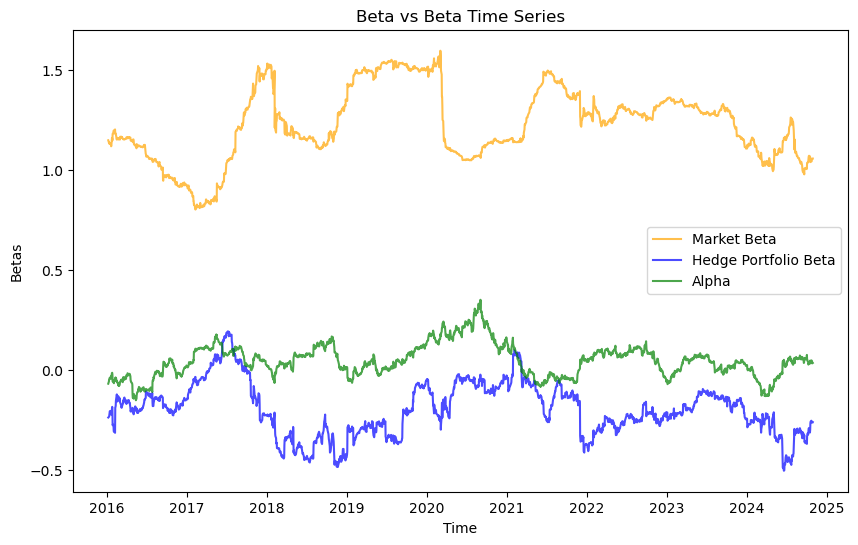

In [325]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_df['benchmark_excess_returns'], label='Market Beta', color='orange', alpha=0.7)
plt.plot(betas_df['hedge_port_excess_returns'], label='Hedge Portfolio Beta', color='blue', alpha=0.7)
plt.plot(betas_df['const'], label='Alpha', color='green', alpha=0.7)

# Config
plt.title('Beta vs Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

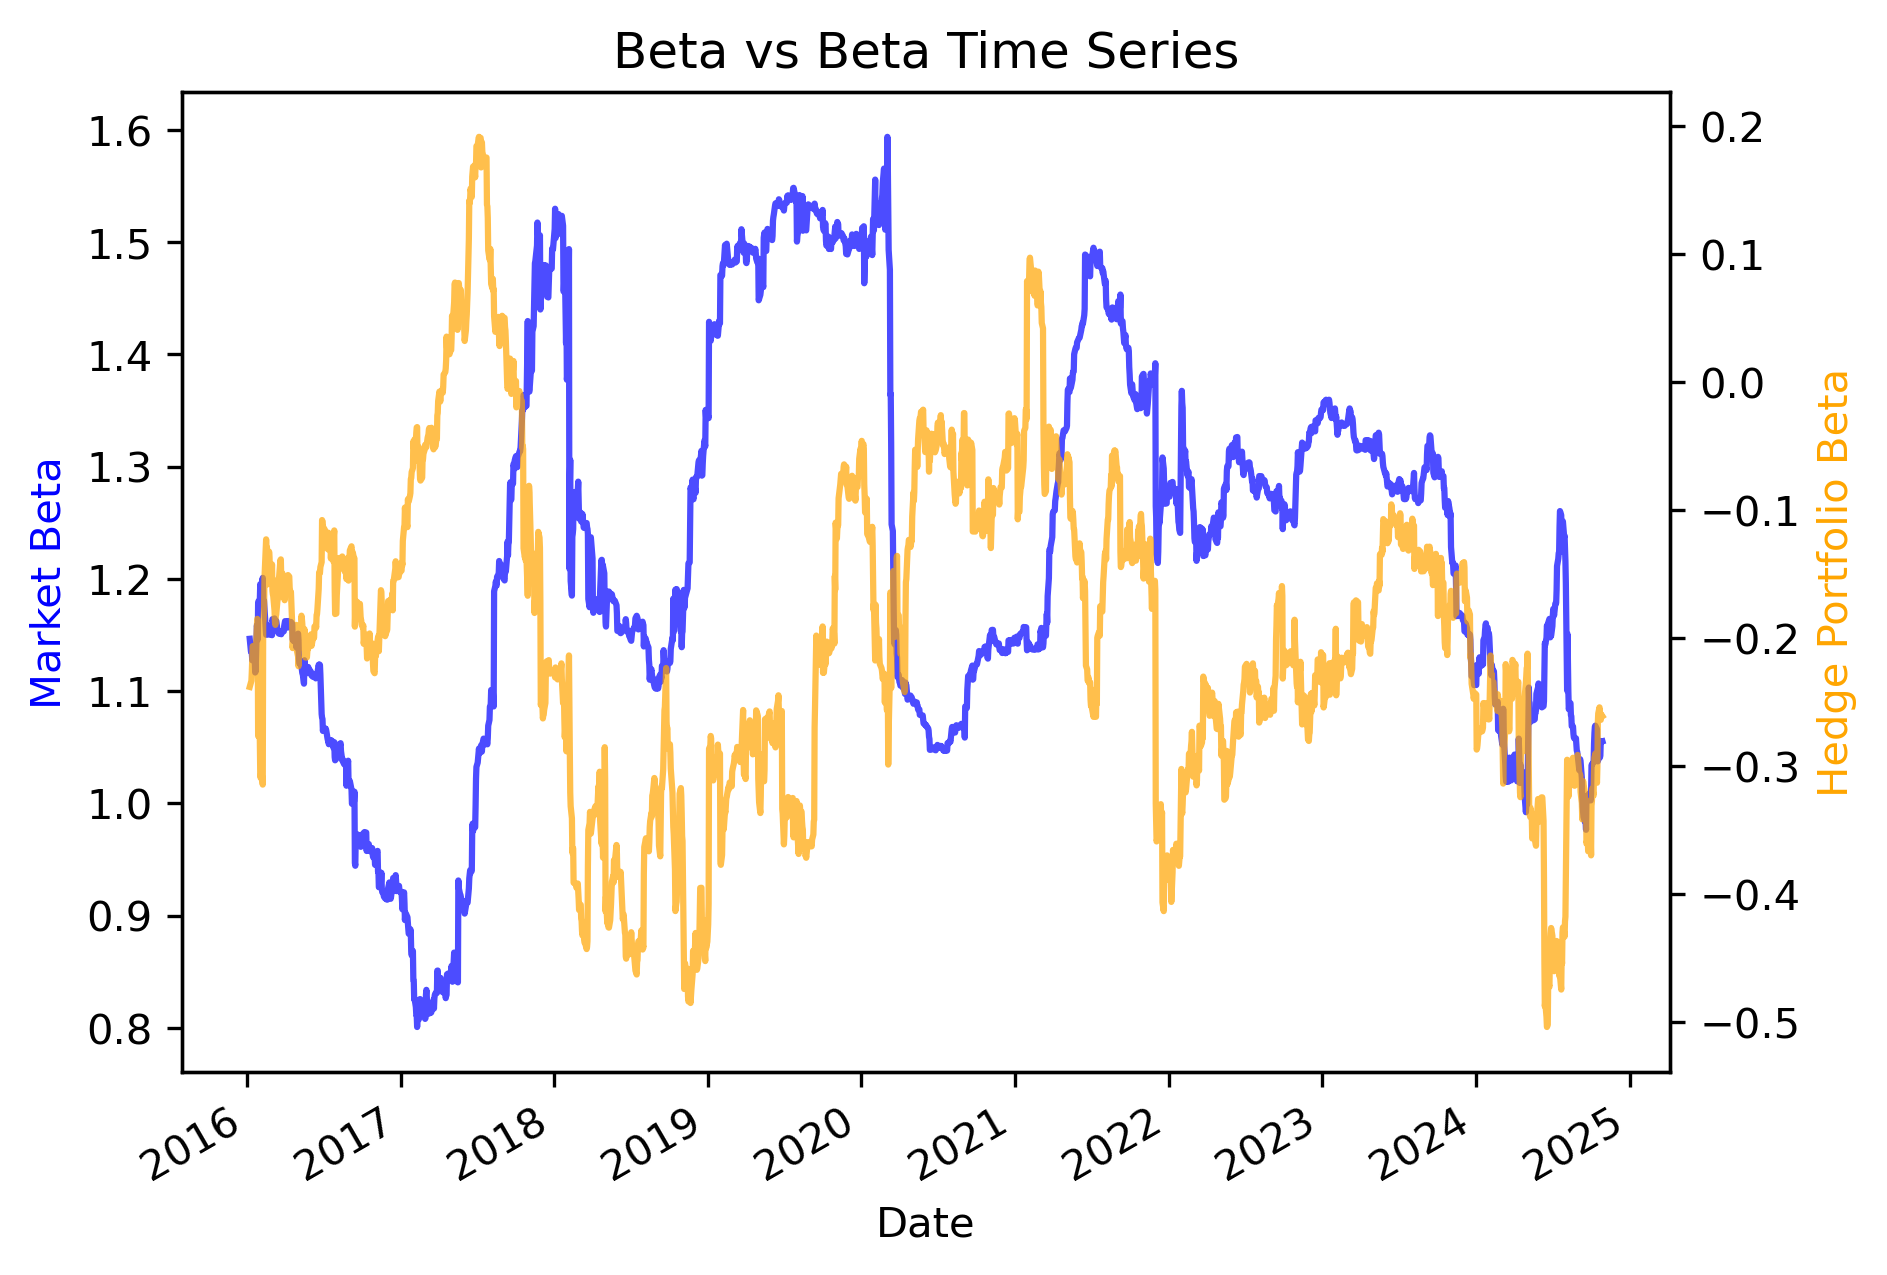

In [326]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Unemployment Rate Plot
betas_df['benchmark_excess_returns'].plot(color = 'blue', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Market Beta', 
    color='blue'
    )

# Unemployment Mentions Plot
ax2 = ax1.twinx()

betas_df['hedge_port_excess_returns'].plot(color = 'orange', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Hedge Portfolio Beta', 
    color='orange'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

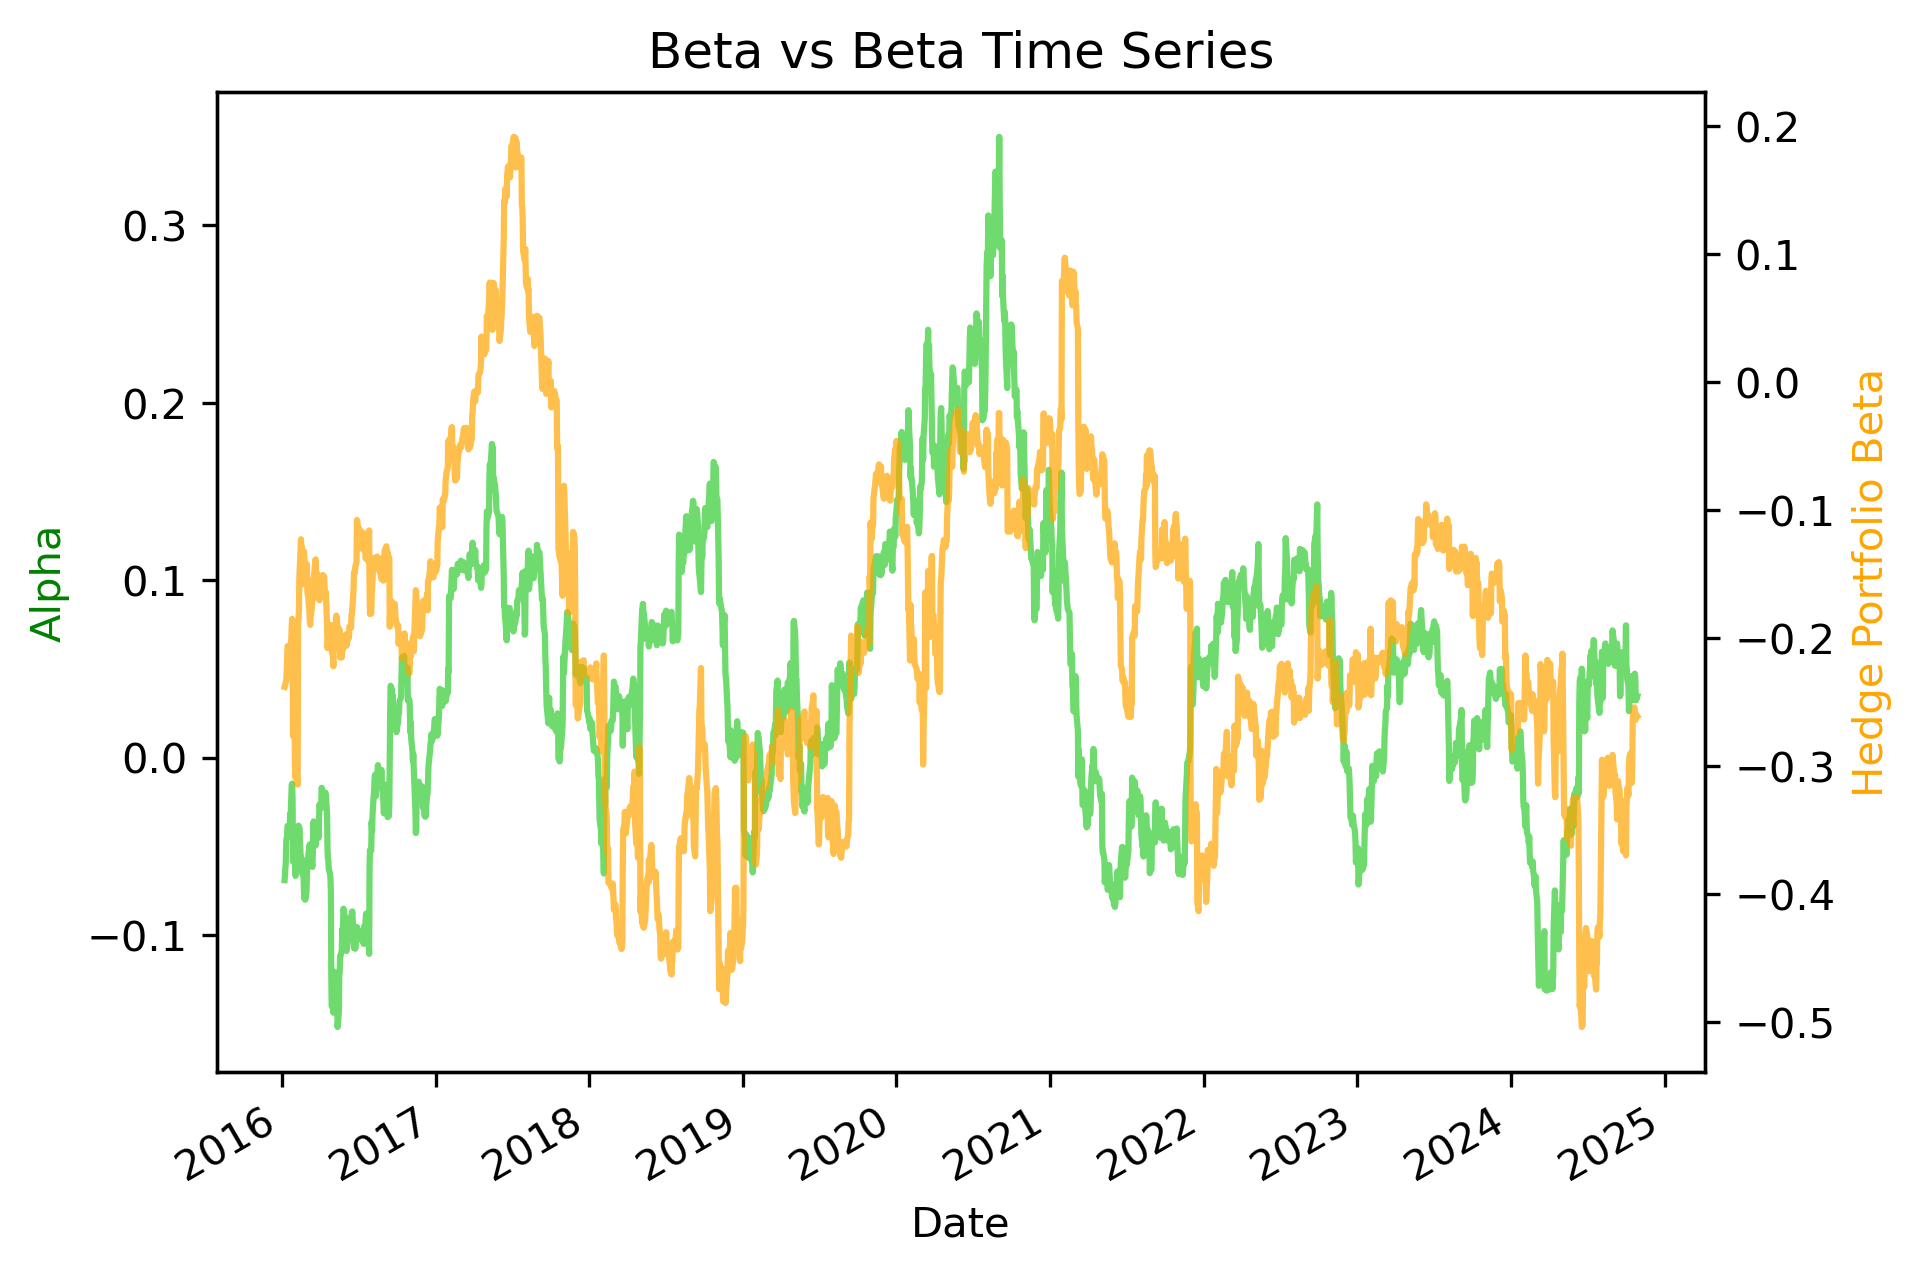

In [327]:
# Create Figure
fig, ax1 = plt.subplots(dpi = 300)

# Unemployment Rate Plot
betas_df['const'].plot(color = 'limegreen', ax = ax1, alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel(
    'Alpha', 
    color='green'
    )

# Unemployment Mentions Plot
ax2 = ax1.twinx()

betas_df['hedge_port_excess_returns'].plot(color = 'orange', ax = ax2, alpha=0.7)
ax2.set_ylabel(
    'Hedge Portfolio Beta', 
    color='orange'
    )

plt.title('Beta vs Beta Time Series')
plt.show()

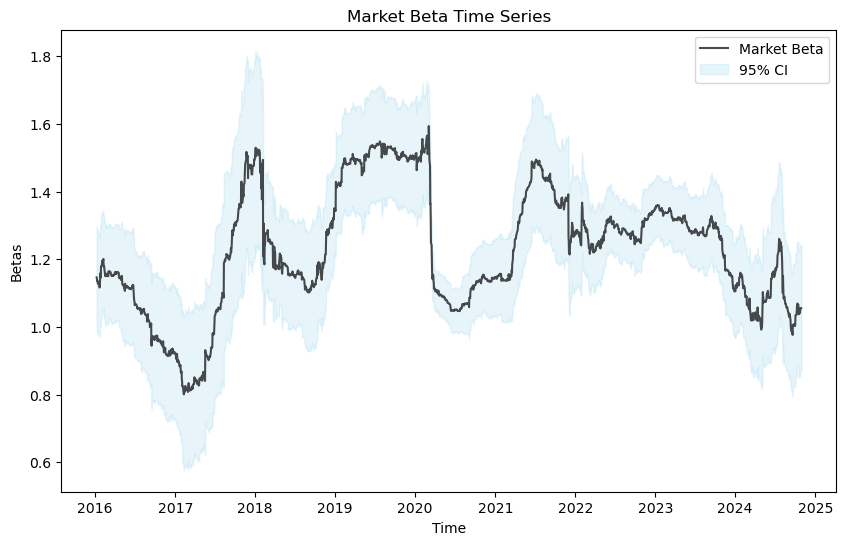

In [328]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_df['benchmark_excess_returns'], label='Market Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['benchmark_excess_returns_lower'], upper_df['benchmark_excess_returns_upper'], color='skyblue', alpha=0.2, label='95% CI')

# Config
plt.title('Market Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

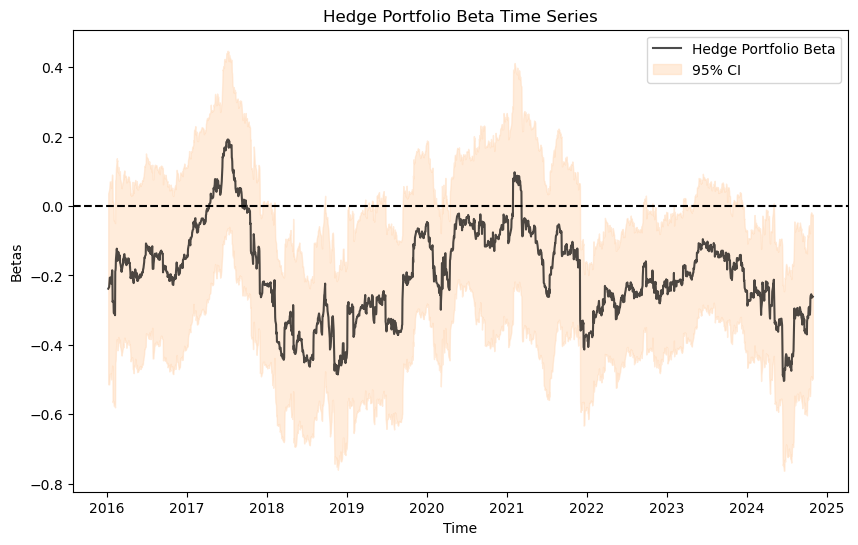

In [329]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(betas_df['hedge_port_excess_returns'], label='Hedge Portfolio Beta', color='black', alpha=0.7)
plt.fill_between(upper_df.index, lower_df['hedge_port_excess_returns_lower'], upper_df['hedge_port_excess_returns_upper'], color='peachpuff', alpha=0.5, label='95% CI')
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Hedge Portfolio Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()

# Show
plt.show()

### Adding Constrains to the Model ###

In [331]:
# Remembering the Form of the Constrained OLS

display(Math(r"\beta=(X^⊤X)^{-1}(X^⊤Y)-P"))
display(Math(r"P=\frac{R^⊤(X^⊤X)^{-1}(X^⊤Y)-q}{R^⊤(X^⊤X)^{-1}R}(X^⊤X)^{-1}R"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [332]:
#Show the betas

model_betas = results.params

model_betas

const                        0.042591
benchmark_excess_returns     1.202646
hedge_port_excess_returns   -0.182641
dtype: float64

In [333]:
# Make the Models using GLM
OLS_from_GLM = sm.GLM(y, x)

result_c = OLS_from_GLM.fit_constrained('benchmark_excess_returns + hedge_port_excess_returns = 1')

#here we check the summary
print(result_c.summary())   

                  Generalized Linear Model Regression Results                   
Dep. Variable:     stock_excess_returns   No. Observations:                 2453
Model:                              GLM   Df Residuals:                     2451
Model Family:                  Gaussian   Df Model:                            1
Link Function:                 Identity   Scale:                          1.4167
Method:                            IRLS   Log-Likelihood:                -3906.9
Date:                  Tue, 08 Apr 2025   Deviance:                       3472.3
Time:                          19:52:34   Pearson chi2:                 3.47e+03
No. Iterations:                       1   Pseudo R-squ. (CS):             0.7243
Covariance Type:              nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
co